# 23_04_25_09_erythroid_lineage_下游分析5_隐层表示从源点到终点的最短路径

> 参考：/mnt/h/F_bak/Python进阶/scRNA/Other/MyRNAVelocity/23_03_07_模型搭建完成后的实验部分/23_03_20_3_原肠胚抽样数据整体串联.ipynb

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import anndata as ad
import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 读取结果

1. adata

In [3]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. model

In [4]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage2/model/model.pt already downloaded                                             


## 2. 隐层表示

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


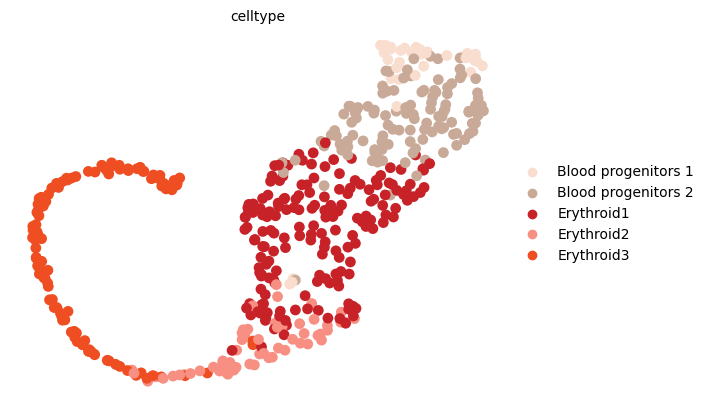

In [5]:
latent_representation = velovgi_model.get_latent_representation(adata)
latent_adata = ad.AnnData(latent_representation)
latent_adata.obs.index = adata.obs.index
latent_adata.obs[batch_key] = adata.obs[batch_key]
latent_adata.obs[cluster_key] = adata.obs[cluster_key]
latent_adata.uns["%s_colors"%cluster_key] = adata.uns["%s_colors"%cluster_key]
# 直接作为主成分进行降维、可视化
latent_adata.obsm["X_pca"] = latent_adata.X.copy()
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
scv.pl.umap(latent_adata, color=cluster_key, legend_loc="right")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_latent_representation_umap', embedded velocity vectors (adata.obsm)


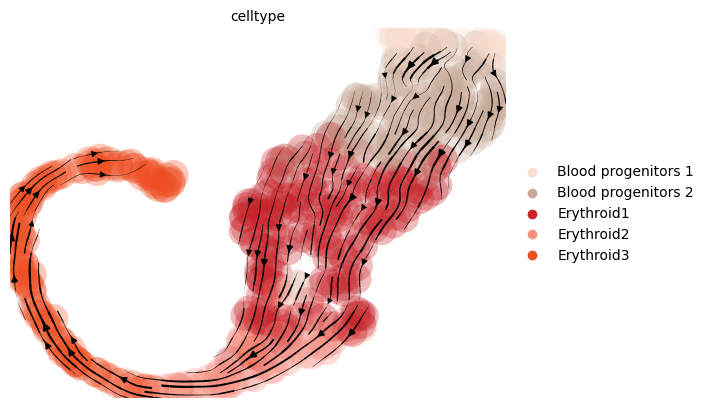

In [6]:
# 重新计算转移概率后可视化速率图
latent_umap_key = "X_latent_representation_umap"
adata.obsm[latent_umap_key] = latent_adata.obsm["X_umap"]
scv.pl.velocity_embedding_stream(adata, color=cluster_key, basis=latent_umap_key, legend_loc="right")

## 3. 最短路径(这里搜索有点问题,比较难看)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

1. 原始降维图上的起点、终点搜索

In [8]:
umap = adata.obsm["X_umap"]

# 找坐标范围
x_min, y_min = umap.min(axis=0)
x_max, y_max = umap.max(axis=0)
print("X(%.2f~%.2f), Y(%.2f~%.2f)"%(x_min, x_max, y_min, y_max))

X(-0.48~10.71), Y(4.81~15.52)


In [9]:
# 找起点、终点
bool_array = (umap[:, 0] < 0.48) # 找左边的细胞作为起点
source = np.arange(bool_array.shape[0])[bool_array][0]
bool_array = (umap[:, 1] < 5)  # 找下边的细胞作为终点
target = np.arange(bool_array.shape[0])[bool_array][0]

umap_points = [source, target]
umap_points, umap[umap_points[0]], umap[umap_points[1]]

([85, 27], array([ 0.06650515, 12.61274779]), array([8.39353107, 4.89491949]))

2. 新降维图上的最短路径起点、终点搜索

In [10]:
latent_umap = adata.obsm["X_latent_representation_umap"]

# 找坐标范围
x_min, y_min = latent_umap.min(axis=0)
x_max, y_max = latent_umap.max(axis=0)
print("X(%.2f~%.2f), Y(%.2f~%.2f)"%(x_min, x_max, y_min, y_max))

X(-2.71~14.20), Y(0.00~17.16)


In [11]:
# 找起点、终点
bool_array = (latent_umap[:, 1] > 12) # 找上边的细胞作为起点
source = np.arange(bool_array.shape[0])[bool_array][0]
bool_array = (latent_umap[:, 0] < -1.2)  # 找左边的细胞作为终点
target = np.arange(bool_array.shape[0])[bool_array][0]

latent_umap_points = [source, target]
umap_points, umap[umap_points[0]], umap[umap_points[1]]

([85, 27], array([ 0.06650515, 12.61274779]), array([8.39353107, 4.89491949]))

3. 绘图

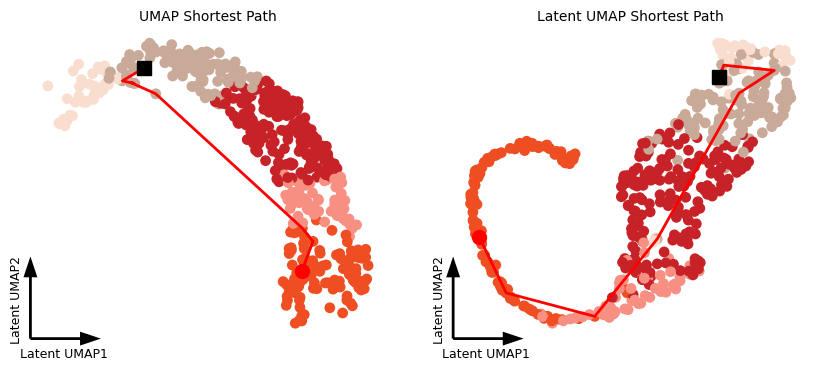

In [12]:
fig, ax=plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

G = nx.from_scipy_sparse_array(adata.obsp["connectivities"])
shortest_path = nx.shortest_path(G, source=source, target=target)
shortest_path_umap = umap[shortest_path]
source_umap = umap[source]
target_umap = umap[target]
ax[0].plot(shortest_path_umap[:, 0], shortest_path_umap[:, 1], color='r', linewidth=2) # 轨迹的终点画圆圈
ax[0].plot(target_umap[0], target_umap[1], color='r', linewidth=2, marker='o', markersize=10) # 轨迹的终点画圆圈
ax[0].plot(source_umap[0], source_umap[1], color='k', linewidth=2, marker='s', markersize=10)# 轨迹的起点画方框
scv.pl.scatter(adata, ax=ax[0], color=cluster_key, basis="X_umap",
               xlabel='Latent UMAP1', ylabel='Latent UMAP2', title="UMAP Shortest Path",
               frameon="artist", legend_loc="none", show=False)

ax[0].xaxis.label.set_size(9)
ax[0].yaxis.label.set_size(9)

G = nx.from_scipy_sparse_array(adata.obsp["connectivities"])
shortest_path = nx.shortest_path(G, source=source, target=target)
shortest_path_umap = latent_umap[shortest_path]
source_umap = latent_umap[latent_umap_points[0]]
target_umap = latent_umap[latent_umap_points[1]]
ax[1].plot(shortest_path_umap[:, 0], shortest_path_umap[:, 1], color='r', linewidth=2) # 轨迹的终点画圆圈
ax[1].plot(target_umap[0], target_umap[1], color='r', linewidth=2, marker='o', markersize=10) # 轨迹的终点画圆圈
ax[1].plot(source_umap[0], source_umap[1], color='k', linewidth=2, marker='s', markersize=10)# 轨迹的起点画方框
scv.pl.scatter(adata, ax=ax[1], color=cluster_key, basis="X_latent_representation_umap",
               xlabel='Latent UMAP1', ylabel='Latent UMAP2', title="Latent UMAP Shortest Path",
               frameon="artist", legend_loc="none", show=False)

ax[1].xaxis.label.set_size(9)
ax[1].yaxis.label.set_size(9)

plt.show()

## 4. CytoPath最短路径搜索优化

In [13]:
scv.tl.terminal_states(adata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 6 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [15]:
import os
import cytopath

adata.uns["T_forward"] = scv.utils.get_transition_matrix(adata)
cytopath.sampling(adata, num_cores=os.cpu_count()-1, cluster_key = cluster_key)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 135
Number of initial simulations (sim_number) set to 484


Iterating state probability distributions:   0%|          | 0/200 [00:00<?, ?it/s]

Tolerance reached after 32 iterations of 200.
Number of initial simulation steps (max_steps) set to 32

Sampling round: 0


  0%|          | 0/11 [00:00<?, ?it/s]

## 3. Dynamo最短路径搜索优化

In [13]:
import dynamo as dyn

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


|-----------> plotting with basis key=X_umap
|-----------> skip filtering celltype by stack threshold when stacking color because it is not a numeric type


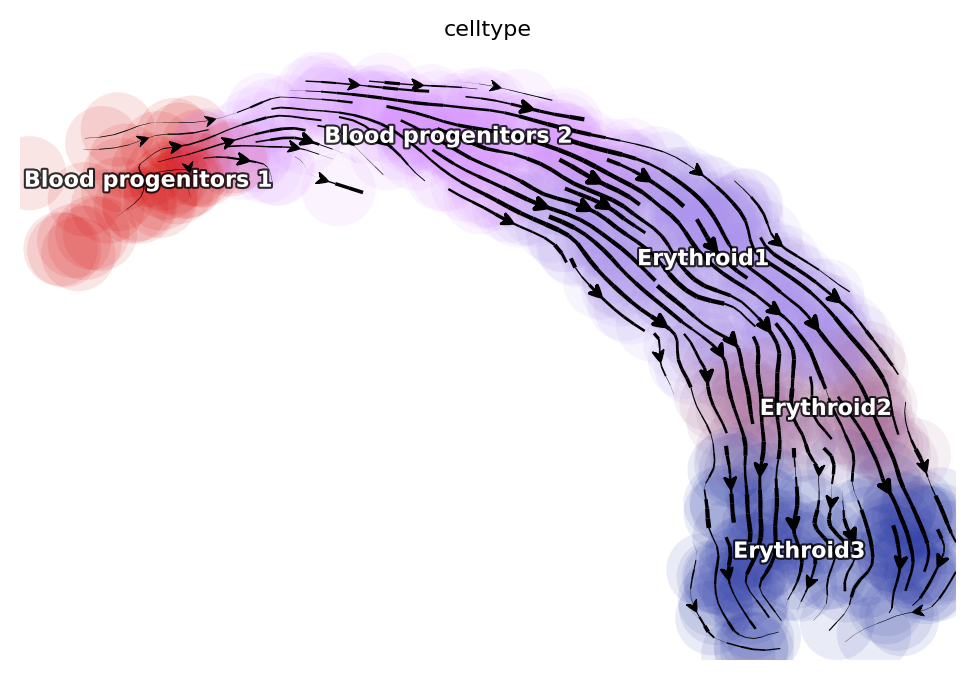

In [14]:
dyn.pl.streamline_plot(adata, basis="umap", color=cluster_key)

In [15]:
from dynamo.tools.utils import nearest_neighbors

extreme_points = np.array(
    [
        [0.06650515, 12.61274779],
        [8.39353107, 4.89491949],
    ]
)

Blood_progenitors_1_cells_indices = nearest_neighbors(extreme_points[0], adata.obsm["X_umap"])
Erythroid3_cells_indices = nearest_neighbors(extreme_points[1], adata.obsm["X_umap"])
Blood_progenitors_1_cells_indices, Erythroid3_cells_indices


(array([[ 85, 186, 331, 333, 290]]), array([[ 27, 185, 495, 217, 316]]))

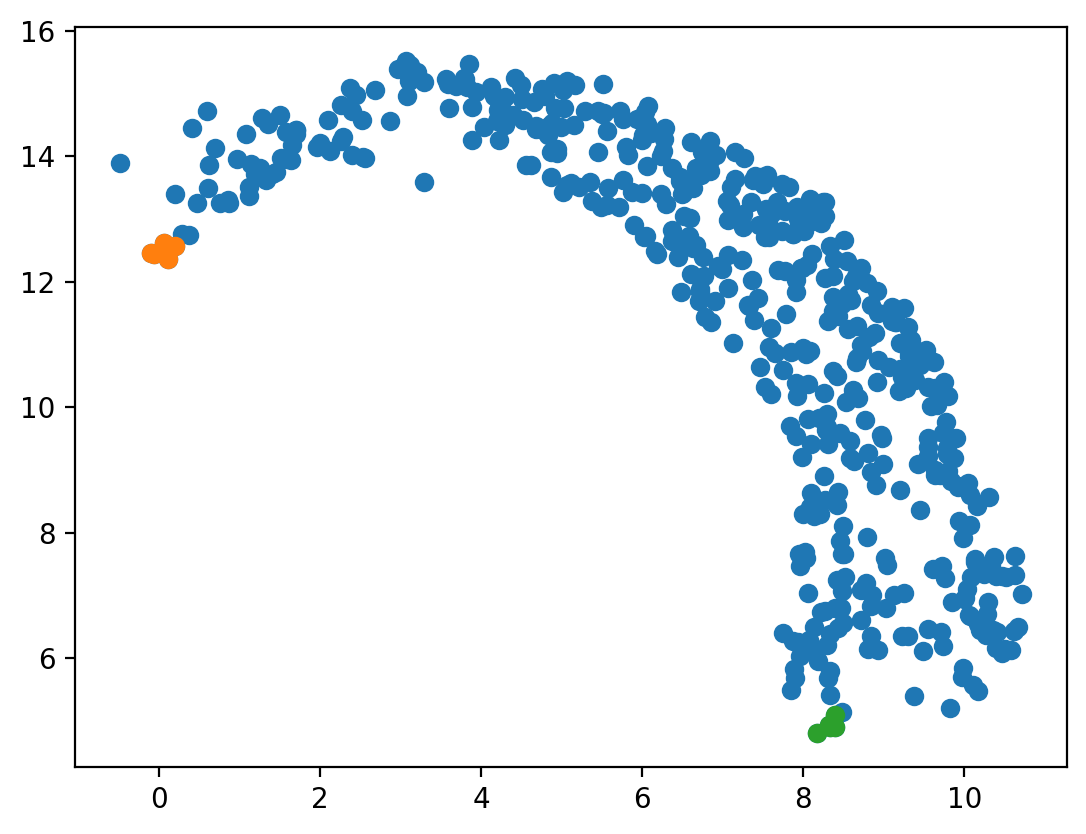

In [16]:
# plt.figure(figsize=(4, 4))
plt.scatter(*adata.obsm["X_umap"].T)
for indices in [
    Blood_progenitors_1_cells_indices,
    Erythroid3_cells_indices,
]:
    plt.scatter(*adata[indices[0]].obsm["X_umap"].T)
plt.show()

In [17]:
dyn.vf.VectorField(adata, basis='umap')
dyn.tl.neighbors(adata, basis="umap", result_prefix="umap")

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.0394s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.1125s]
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recompu

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid', 'VecFld_umap', 'umap_neighbors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'X_latent_representation_umap', 'velocity_latent_representation_umap', 'velocity_umap_SparseVFC', 'X_umap_SparseVFC'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances', 'umap_distances', 'umap_connectivities'

In [18]:

adata.obsp["X_umap_distances"] = adata.uns["neighbors"]["distances"] # 临时构造的邻居
use_for_pca

In [25]:
adata.obs["celltype"]

GAGTGGGACTGAGT    Blood progenitors 2
AGACCTGACCTCCA             Erythroid1
ACAGTGTGCCCTCA             Erythroid2
AGTCCAGATAAGCC             Erythroid1
GGCGCATGTTGCGA    Blood progenitors 1
                         ...         
GAGCAGGAACCAGT             Erythroid3
ATCCCGTGCATGGT             Erythroid2
ACCACCTGTATCGG             Erythroid2
AAACCGTGGTGTTG             Erythroid1
GGATGTTGCTGGAT             Erythroid1
Name: celltype, Length: 500, dtype: category
Categories (5, object): ['Blood progenitors 1', 'Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']

In [26]:
transition_graph = {}
cell_type = ["Blood progenitors 1", "Erythroid3"]
start_cell_indices = [
    Blood_progenitors_1_cells_indices,
    Erythroid3_cells_indices
]
end_cell_indices = [
    Blood_progenitors_1_cells_indices,
    Erythroid3_cells_indices
]
for i, start in enumerate(start_cell_indices):
    for j, end in enumerate(end_cell_indices):
        if start is not end:
            min_lap_t = True if i == 0 else False
            dyn.pd.least_action(
                adata,
                [adata.obs_names[start[0]][0]],
                [adata.obs_names[end[0]][0]],
                basis="umap",
                adj_key="X_umap_distances",
                min_lap_t= min_lap_t,
                EM_steps=2,
            )
            dyn.pl.least_action(adata, basis="umap")
            lap = dyn.pd.least_action(
                adata,
                [adata.obs_names[start[0]][0]],
                [adata.obs_names[end[0]][0]],
                basis="pca",
                adj_key="cosine_transition_matrix",
                min_lap_t=min_lap_t,
                EM_steps=2,
            )
            dyn.pl.kinetic_heatmap(
                adata,
                basis="pca",
                mode="lap",
                genes=adata.var_names[adata.var.use_for_transition],
                project_back_to_high_dim=True,
            )
            # The `GeneTrajectory` class can be used to output trajectories for any set of genes of interest
            # 计算轨迹
            gtraj = dyn.pd.GeneTrajectory(adata)
            gtraj.from_pca(lap.X, t=lap.t)
            gtraj.calc_msd()
            ranking = dyn.vf.rank_genes(adata, "traj_msd")

            print(start, "->", end)
            genes = ranking[:5]["all"].to_list()
            arr = gtraj.select_gene(genes)

            dyn.pl.multiplot(lambda k: [plt.plot(arr[k, :]), plt.title(genes[k])], np.arange(len(genes)))

            transition_graph[cell_type[i] + "->" + cell_type[j]] = {
                "lap": lap,
                "LAP_umap": adata.uns["LAP_umap"],
                "LAP_pca": adata.uns["LAP_pca"],
                "ranking": ranking,
                "gtraj": gtraj,
            }


|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.001524
|-----> [iterating through 1 pairs] in progress: 100.0000%
|-----> [iterating through 1 pairs] finished [7.7001s]


AttributeError: 'DataFrame' object has no attribute 'use_for_pca'